# 0. Setup

In [1]:
!pip install ucimlrepo
!pip install minisom

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from minisom import MiniSom
from ucimlrepo import fetch_ucirepo

# Fetch and load the Dry Bean dataset using ucimlrepo
dry_bean = fetch_ucirepo(id=602)
X = dry_bean.data.features
y = dry_bean.data.targets.iloc[:, 0]
class_labels = y.unique()

In [3]:
dry_bean.variables

,name,role,type,demographic,description,units,missing_values
0,Area,Feature,Integer,None,The area of a bean zone and the number of pixe...,pixels,no
1,Perimeter,Feature,Continuous,None,Bean circumference is defined as the length of...,None,no
2,MajorAxisLength,Feature,Continuous,None,The distance between the ends of the longest l...,None,no
3,MinorAxisLength,Feature,Continuous,None,The longest line that can be drawn from the be...,None,no
4,AspectRatio,Feature,Continuous,None,Defines the relationship between MajorAxisLeng...,None,no
5,Eccentricity,Feature,Continuous,None,Eccentricity of the ellipse having the same mo...,None,no
6,ConvexArea,Feature,Integer,None,Number of pixels in the smallest convex polygo...,None,no
7,EquivDiameter,Feature,Continuous,None,Equivalent diameter: The diameter of a circle ...,None,no
8,Extent,Feature,Continuous,None,The ratio of the pixels in the bounding box to...,None,no
9,Solidity,Feature,Continuous,None,Also known as convexity. The ratio of the pixe...,None,no


# 1. Plot and Interpret Boxplots

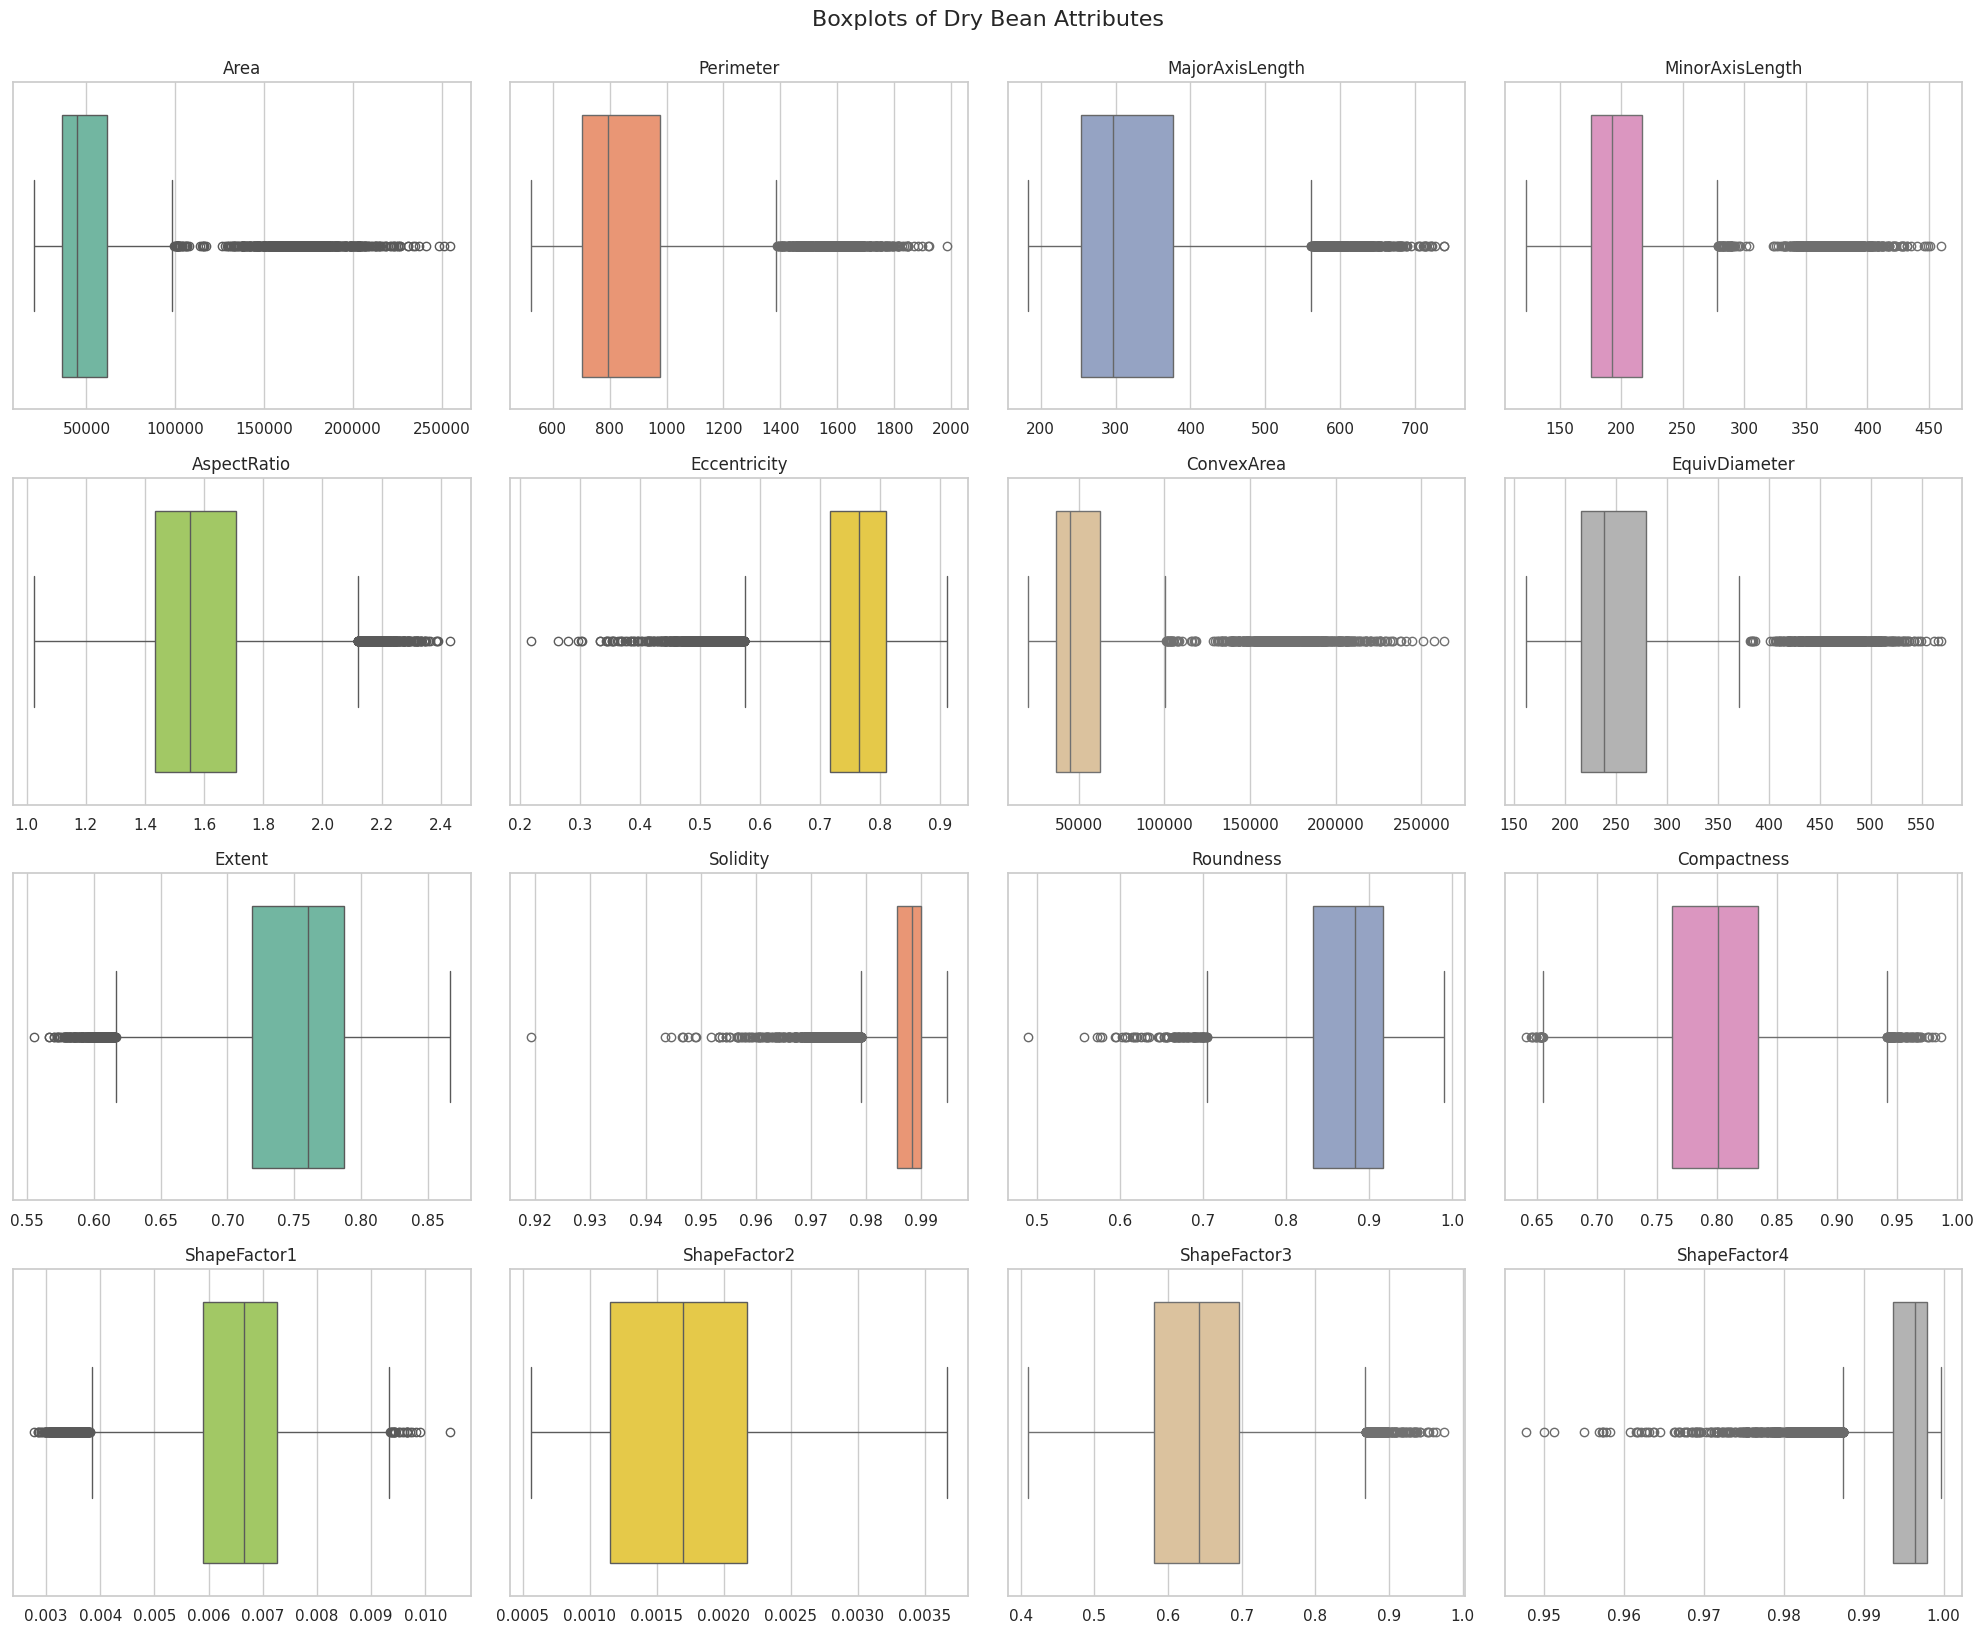

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 16))
axes = axes.flatten()
palette = sns.color_palette("Set2")

# Plot each attribute's boxplot horizontally
for i, column in enumerate(X.columns):
    sns.boxplot(x=X[column], ax=axes[i], color=palette[i % len(palette)])
    axes[i].set_title(column, fontsize=12)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.suptitle("Boxplots of Dry Bean Attributes", fontsize=16, y=1.02)
plt.show()

In a first glance, all the features except ShapeFactor contains many outliers. Outliers lies in the upper end of the range especilly in area related features such as AspectRation, ConvexArea, EquivDiameeter, whereas it is lower end for features Eccentricity, Extend, Solidity and Roundness. All of features have a short interquartile range indicating the compactance of the data. When it comes to the distribution of the data for features, many of them showed normal distribution with different mean and variance, showed skewness to left or right end of the distribution.

# 2. Z-Score Normalization and Fisher Distance Analysis

In [5]:
def calculate_fisher_distance(X, y):
    class_labels = y.unique()
    C = len(class_labels)
    fisher_scores = {}
    for i in range(X.shape[1]):
        total_fd = 0
        for j in range(C):
            for k in range(j+1, C):
                group_j = X.loc[y == class_labels[j], X.columns[i]]
                group_k = X.loc[y == class_labels[k], X.columns[i]]
                mu_diff = abs(group_j.mean() - group_k.mean())
                std_sum = np.sqrt(group_j.var() + group_k.var())
                total_fd += mu_diff / std_sum if std_sum != 0 else 0
        fisher_scores[X.columns[i]] = (2 / (C * (C - 1))) * total_fd
    return dict(sorted(fisher_scores.items(), key=lambda item: item[1], reverse=True))

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
fisher_scores = calculate_fisher_distance(X_scaled_df, y, )

print("Fisher Scores:")
for k, v in fisher_scores.items():
    print(f"{k}: {v:.4f}")

Fisher Scores:
EquivDiameter: 3.2778
Perimeter: 3.2119
MinorAxisLength: 3.1344
ShapeFactor1: 3.1215
MajorAxisLength: 2.9482
Area: 2.9035
ConvexArea: 2.9027
ShapeFactor2: 2.3974
Compactness: 1.8473
ShapeFactor3: 1.8223
AspectRatio: 1.8027
Eccentricity: 1.5937
Roundness: 1.5048
ShapeFactor4: 0.7290
Solidity: 0.5141
Extent: 0.3750


The results in Table~\ref{tab:fisher_scores} indicate that EquivDiameter, Perimeter, and MinorAxisLength have the highest Fisher Scores, suggesting they are the most discriminative features for class separation in this dataset. These geometric features likely capture significant shape or size variations across classes, which contribute to their high class separability.

In contrast, features like Solidity, Extent, and ShapeFactor4 exhibit very low Fisher Scores, implying they contribute minimally to class discrimination. These features might be relatively consistent across different classes or less relevant to the specific patterns the model is trying to learn.

Overall, the results suggest that emphasizing high-ranking features (e.g., the top 5–7) during feature selection could improve classification performance while reducing dimensionality.

# 3. PCA Transformation and Fisher Distance Comparison

In [7]:
from sklearn.decomposition import PCA

# PCA transformation
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Fisher Distance on PCA-transformed features
fisher_pca = calculate_fisher_distance(pd.DataFrame(X_pca), y)

# Compare Fisher Scores with Eigenvalues
explained_var = pca.explained_variance_ratio_

# Print both for comparison
print(f"{'PC':<6} {'Explained Var':<15} {'Fisher Score':<15}")
for i, (ev, fs) in enumerate(zip(explained_var, fisher_pca.values())):
    print(f"PC{i+1:<3} {ev:<15.4f} {fs:<15.4f}")

PC     Explained Var   Fisher Score   
PC1   0.5547          2.8558         
PC2   0.2643          2.4563         
PC3   0.0801          1.1114         
PC4   0.0511          0.7795         
PC5   0.0274          0.7703         
PC6   0.0115          0.4922         
PC7   0.0070          0.4819         
PC8   0.0033          0.4768         
PC9   0.0005          0.3897         
PC10  0.0001          0.3297         
PC11  0.0001          0.2757         
PC12  0.0000          0.2565         
PC13  0.0000          0.2350         
PC14  0.0000          0.1734         
PC15  0.0000          0.1302         
PC16  0.0000          0.0754         


In this part, we applied the generalized Fisher Distance method as outlined in Li et al. (2017), “Feature Selection for High-Dimensional Data: A Partial Survey”. This method extends the classical Fisher criterion — originally designed for binary class separation — to multi-class scenarios by averaging the pairwise Fisher scores across all class combinations, providing a robust measure of feature discriminative power in the presence of multiple classes.

After transforming the dataset using Principal Component Analysis (PCA), each principal component (PC) was treated as a new derived feature, and its Fisher Distance was computed to assess the degree of class separation along that dimension. The analysis revealed a strong correspondence between the explained variance of each PC and its Fisher Distance. Specifically, the first principal component (PC1), which explained approximately 55.47% of the total variance, exhibited the highest Fisher Distance (11.90), indicating that it captures both the largest share of the dataset’s variability and the most pronounced class separability. Similarly, PC2 accounted for 26.43% of the variance and achieved a Fisher Distance of 8.95. In contrast, the remaining components (PC3–PC16) displayed progressively lower explained variance and markedly reduced Fisher scores; notably, components PC10–PC16 contributed almost no variance and had Fisher scores near zero, reflecting minimal class-discriminative capacity.

It is important to emphasize that PCA is an unsupervised dimensionality reduction technique; it identifies directions of maximum variance in the data without incorporating any class label information. As a result, while PCA effectively compresses data into a reduced set of dimensions, these transformed components do not necessarily optimize class separability. Consequently, the Fisher Distance values calculated on the PCA-transformed features are generally lower compared to those computed directly on the original features, where the feature values inherently reflect supervised (class-based) information. This distinction underscores the trade-off between variance preservation and class discrimination when applying unsupervised techniques like PCA in supervised learning contexts.

# 4. Scatter Plot Visualization

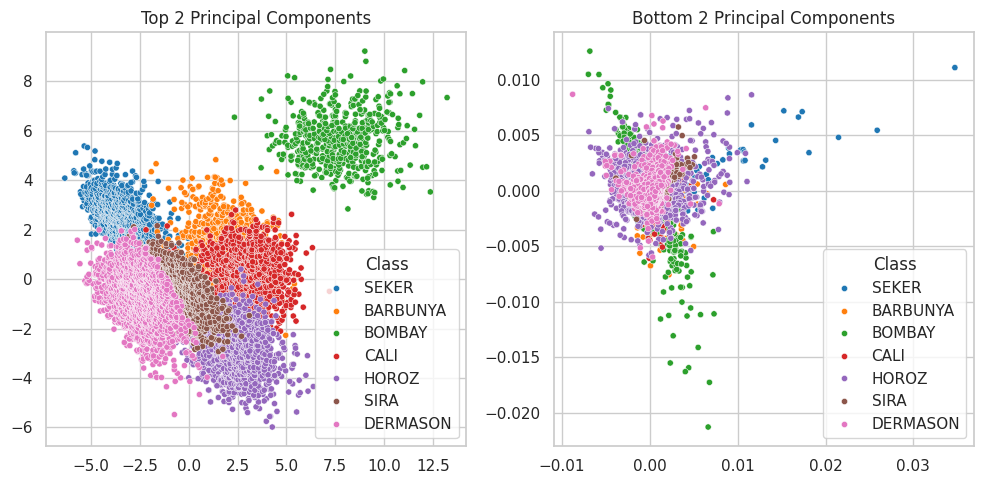

In [8]:
# Top 2 components
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="tab10", s=20)
plt.title("Top 2 Principal Components")

# Bottom 2 components
plt.subplot(1,2,2)
sns.scatterplot(x=X_pca[:,-2], y=X_pca[:,-1], hue=y, palette="tab10", s=20)
plt.title("Bottom 2 Principal Components")
plt.tight_layout()
plt.show()

To evaluate the effectiveness of principal components in representing data variance and enabling class discrimination, two scatter plots were analyzed: one displaying the projection onto the first two principal components (PC1 and PC2) and another using the last two components (PC15 and PC16).

The projection onto PC1 and PC2 captures over 80% of the total variance in the dataset, indicating that these components retain the majority of the original data's structural information. The scatter plot reveals distinct clustering patterns or directional groupings that correspond to different bean types, suggesting a high degree of class separability.

This visual pattern aligns with the outcomes in part 2 where high Fisher Scores observed for PC1 (11.90) and PC2 (8.95), confirming their strong discriminative power. The combination of substantial variance capture and effective class separation emphasizes the relevance of these components for both data representation and classification.


In contrast, the projection onto PC15 and PC16 accounts for an almost negligible amount of variance (0.0000). The corresponding Fisher Scores for these components are also minimal (0.0126 for PC15 and 0.0019 for PC16), indicating a lack of discriminative capacity. The scatter plot reflects this, displaying a noisy and overlapping distribution with no discernible class structure.

These results suggest that PC15 and PC16 carry little to no information regarding either the intrinsic variance of the dataset or meaningful class distinctions.

The graphical representations corroborate the numerical analysis of component relevance. Principal components with the highest variance—particularly PC1 and PC2—not only dominate in terms of data variance but also play a critical role in distinguishing between classes. Conversely, lower-ranked components such as PC15 and PC16 contribute neither to variance representation nor to class separation. These findings support the exclusion of such components in dimensionality reduction processes and underscore the importance of selecting components based on both variance and class discriminative metrics.

# 5. Dimensionality Reduction with LDA

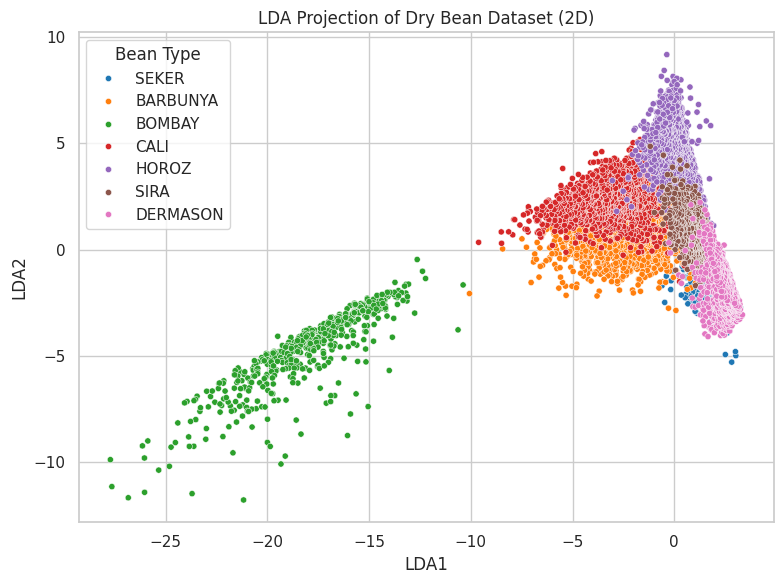

In [9]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y)

lda_df = pd.DataFrame(X_lda, columns=["LDA1", "LDA2"])
lda_df["Label"] = y

plt.figure(figsize=(8, 6))
sns.scatterplot(data=lda_df, x="LDA1", y="LDA2", hue="Label", palette="tab10", s=20)

plt.title("LDA Projection of Dry Bean Dataset (2D)")
plt.xlabel("LDA1")
plt.ylabel("LDA2")
plt.legend(title="Bean Type")
plt.grid(True)
plt.tight_layout()
plt.show()

LDA vs PCA:

- PCA maximizes variance regardless of class labels.

- LDA maximizes class separability using label information.

Expected Result:

- LDA should provide better class separation visually and in terms of Silhouette Score, especially if classes are well-separated in original space.

Metric Used: Silhouette Score is a good unsupervised metric that evaluates how similar an object is to its own cluster (cohesion) compared to other clusters (separation).

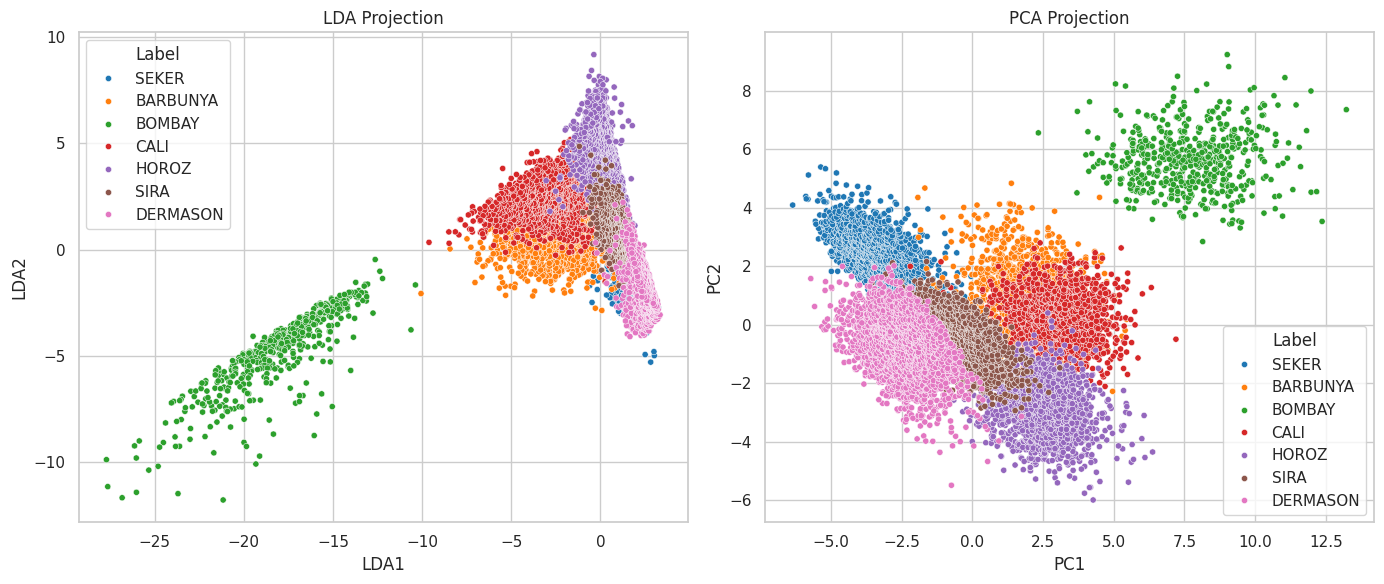

Silhouette Score (LDA): 0.2105
Silhouette Score (PCA): 0.3347


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import silhouette_score

# Prepare DataFrames for Seaborn
lda_df = pd.DataFrame(X_lda, columns=["LDA1", "LDA2"])
lda_df["Label"] = y

pca_df = pd.DataFrame(X_pca[:, :2], columns=["PC1", "PC2"])
pca_df["Label"] = y

# Set up side-by-side subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot LDA with Seaborn
sns.scatterplot(data=lda_df, x="LDA1", y="LDA2", hue="Label", palette="tab10", s=20, ax=axs[0])
axs[0].set_title("LDA Projection")
axs[0].grid(True)

# Plot PCA with Seaborn
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Label", palette="tab10", s=20, ax=axs[1])
axs[1].set_title("PCA Projection")
axs[1].grid(True)

plt.tight_layout()
plt.show()

# Bonus: Silhouette Score
sil_lda = silhouette_score(X_lda, y)
sil_pca = silhouette_score(X_pca[:, :2], y)

print(f"Silhouette Score (LDA): {sil_lda:.4f}")
print(f"Silhouette Score (PCA): {sil_pca:.4f}")

In this part, we applied Linear Discriminant Analysis (LDA) to reduce the dataset to two dimensions and visualized the projection in a scatter plot, with each class shown in a different color. We then compared this to the two-dimensional projection obtained using Principal Component Analysis (PCA) from part 4.

Theoretically, LDA is a supervised dimensionality reduction method that aims to maximize class separability by projecting data along directions that increase the between-class variance and reduce the within-class variance. PCA, on the other hand, is an unsupervised method that maximizes overall variance, regardless of class labels.

Visually, The BOMBAY class is clearly distinguishable in both visualizations. However the PCA projection (right plot) shows better separation between some of the major classes, compared to the LDA projection (left plot), where several classes remain tightly clustered with significant overlap.

To quantify this, we calculated the average silhouette score for both projections:

- PCA projection: 0.3347
- LDA projection: 0.2105

The silhouette score, which ranges from -1 (poor separation) to +1 (well-separated clusters), confirms that the PCA projection unexpectedly achieves better separation between classes in this dataset.

This outcome might seem counterintuitive, as LDA is expected to perform better in supervised settings. However, several factors may explain the result:
- Dimensionality limits: LDA can produce at most C−1C−1 components for CC classes, so reducing to 2D may compress some class distinctions.
- Data characteristics: If the largest sources of variance in the data align well with class differences, PCA can perform surprisingly well, despite being unsupervised.
- Overlap in class distributions: If some classes are not linearly separable, LDA’s linear projections might not effectively untangle them.

Overall, while LDA is designed for discrimination, in this specific dataset and dimensionality, PCA provided better-separated clusters, both visually and according to silhouette scores.

# 6. Clustering with K-Means, DBSCAN, t-SNE, and SOM

## K-Means

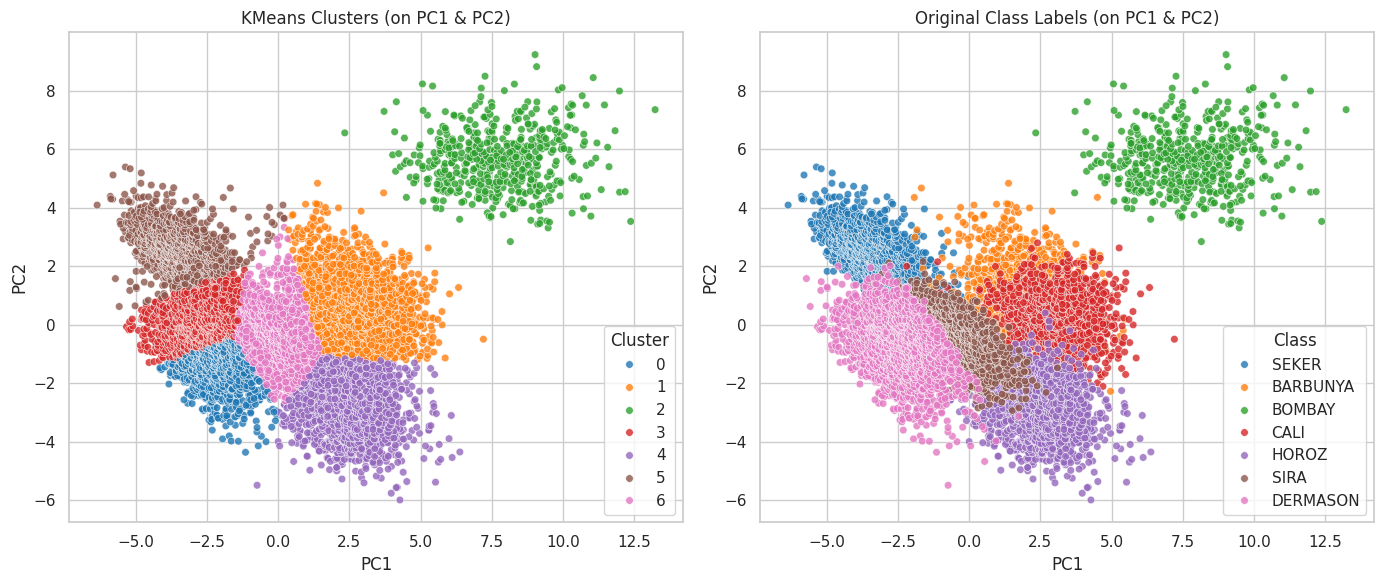

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Fit KMeans on PC1 and PC2
kmeans = KMeans(n_clusters=7, random_state=0)
k_labels = kmeans.fit_predict(X_pca[:, :2])

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=k_labels, palette="tab10",
    s=30, edgecolor='w', alpha=0.8, ax=axes[0]
)
axes[0].set_title("KMeans Clusters (on PC1 & PC2)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")
axes[0].legend(title="Cluster")

sns.scatterplot(
    x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="tab10",
    s=30, edgecolor='w', alpha=0.8, ax=axes[1]
)
axes[1].set_title("Original Class Labels (on PC1 & PC2)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")
axes[1].legend(title="Class")

plt.tight_layout()
plt.show()

## DBSCAN

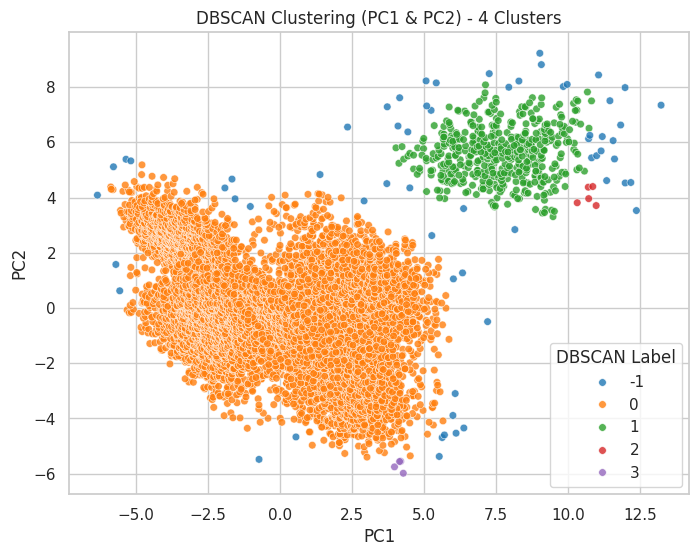

Silhouette Score (DBSCAN): 0.3928


In [12]:
from sklearn.cluster import DBSCAN

# eps is the maximum distance for a point to be considered as part of a neighborhood
dbscan = DBSCAN(eps=0.5, min_samples=5)
y_db = dbscan.fit_predict(X_pca[:, :2])

df_dbscan = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': y_db
})

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_dbscan,
    x='PC1',
    y='PC2',
    hue='Cluster',
    palette=sns.color_palette("tab10", len(set(y_db))),
    s=30,
    edgecolor='w',
    alpha=0.8
)

plt.title(f"DBSCAN Clustering (PC1 & PC2) - {len(set(y_db)) - (1 if -1 in y_db else 0)} Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="DBSCAN Label")
plt.show()

sil_dbscan = silhouette_score(X_pca[:, :2], y_db)
print(f"Silhouette Score (DBSCAN): {sil_dbscan:.4f}")

## t-SNE

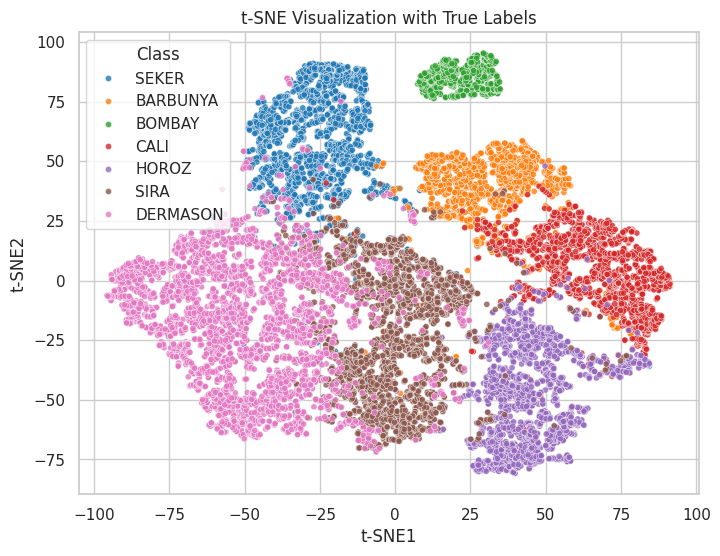

Silhouette Score (t-SNE): 0.3253


In [13]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X_scaled)

# Visualize with actual class labels
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette="tab10", alpha=0.8, s=20)
plt.title("t-SNE Visualization with True Labels")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.show()

sil_tsne = silhouette_score(X_tsne, y)
print(f"Silhouette Score (t-SNE): {sil_tsne:.4f}")

## SOM

In [25]:
from minisom import MiniSom

# Define SOM parameters
som_shape = (10, 10)  # grid size

# Initialize SOM
som = MiniSom(som_shape[0], som_shape[1], X_scaled.shape[1], sigma=1.5, learning_rate=.5)

# Initialize weights randomly
som.random_weights_init(X_scaled)
# som.pca_weights_init(X_scaled)

# Train the SOM
som.train_random(X_scaled, 1000)  # 1000 iterations

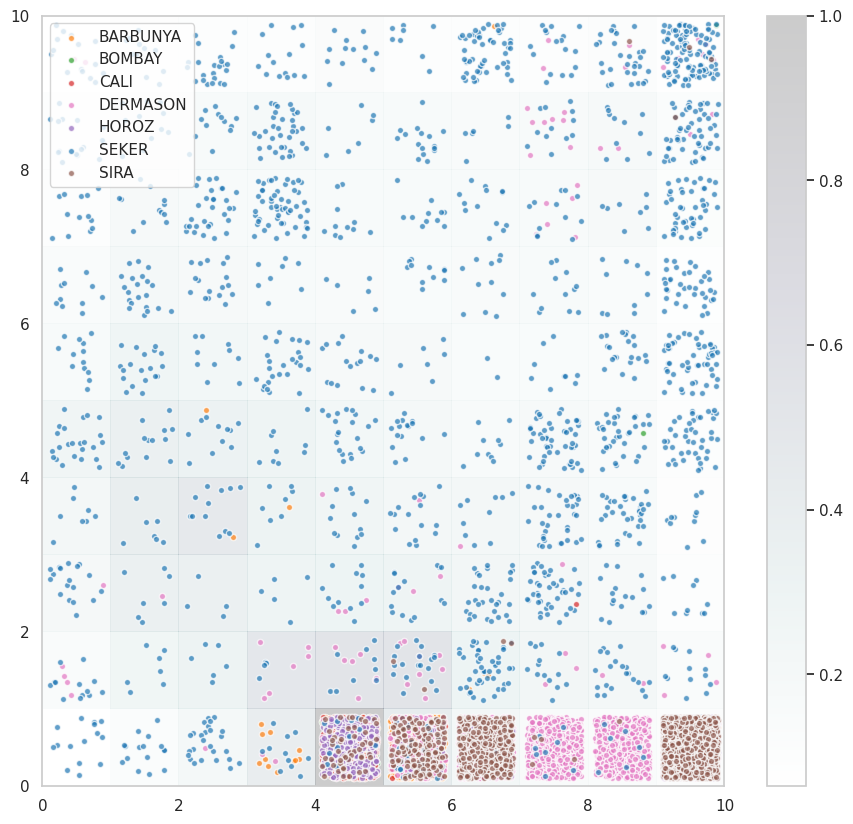

In [27]:
w_x, w_y = zip(*[som.winner(x) for x in X_scaled])
w_x = np.array(w_x)
w_y = np.array(w_y)

# Define the color palette
unique_classes = y.unique()
palette = sns.color_palette("tab10", n_colors=len(unique_classes))
colors_in_order = [palette[i] for i, cls in enumerate(unique_classes)]

# Create a mapping of classes to colors
class_colors = {cls: palette[i] for i, cls in enumerate(unique_classes)}

plt.figure(figsize=(11, 10))
plt.pcolor(som.distance_map().T, cmap='bone_r', alpha=.2)
plt.colorbar()

for c in np.unique(y):
    idx_target = y == c
    plt.scatter(w_x[idx_target] + 0.5 + (np.random.rand(np.sum(idx_target)) - 0.5) * 0.8,
                w_y[idx_target] + 0.5 + (np.random.rand(np.sum(idx_target)) - 0.5) * 0.8,
                s=20, label=c, alpha=0.7, edgecolor='w', color=class_colors[c])

plt.legend(loc='upper left')
plt.grid()
plt.show()

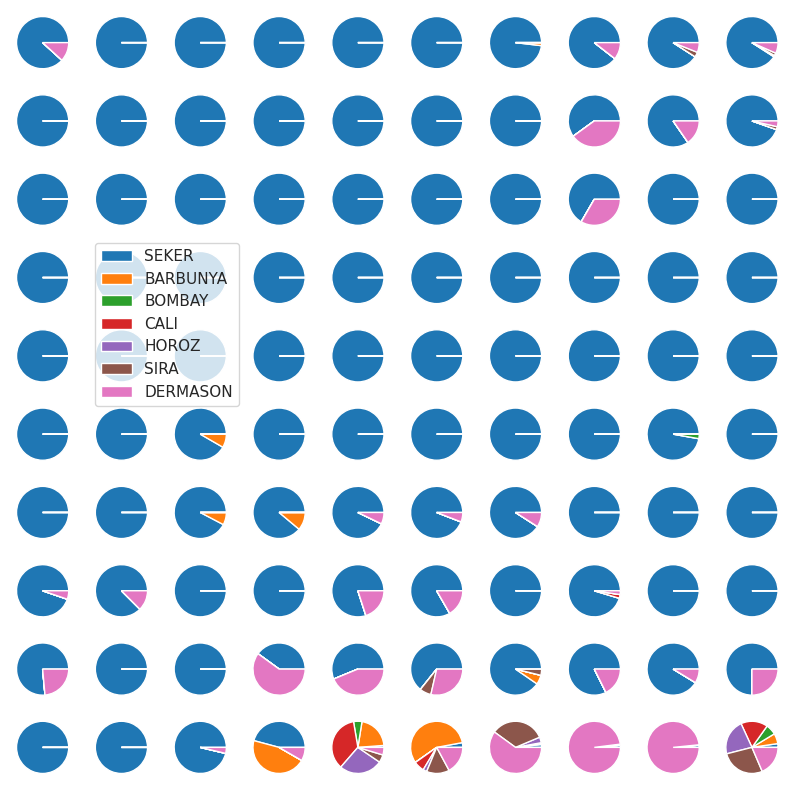

In [31]:
import matplotlib.gridspec as gridspec

labels_map = som.labels_map(X_scaled, y)

fig = plt.figure(figsize=(10, 10))
the_grid = gridspec.GridSpec(som_shape[0], som_shape[1], fig)
for position in labels_map.keys():
    label_fracs = [labels_map[position][y] for y in y.unique()]
    plt.subplot(the_grid[som_shape[1] - 1 - position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs, colors=colors_in_order)

plt.legend(labels=y.unique(), loc="best", bbox_to_anchor=(0, -0.05), ncol=1)
plt.show()

# 7. Outlier Detection and Data Cleaning

In [17]:
from sklearn.ensemble import IsolationForest

# Initialize and fit the Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
outlier_preds = iso_forest.fit_predict(X_scaled)

# -1 means outlier, 1 means inlier
mask = outlier_preds != -1
X_clean = X_scaled[mask]
y_clean = y[mask]

# Print results
print(f"Original sample size: {X_scaled.shape[0]}")
print(f"Cleaned sample size: {X_clean.shape[0]}")
print(f"Number of outliers detected and removed: {X_scaled.shape[0] - X_clean.shape[0]}")

Original sample size: 13611
Cleaned sample size: 13474
Number of outliers detected and removed: 137


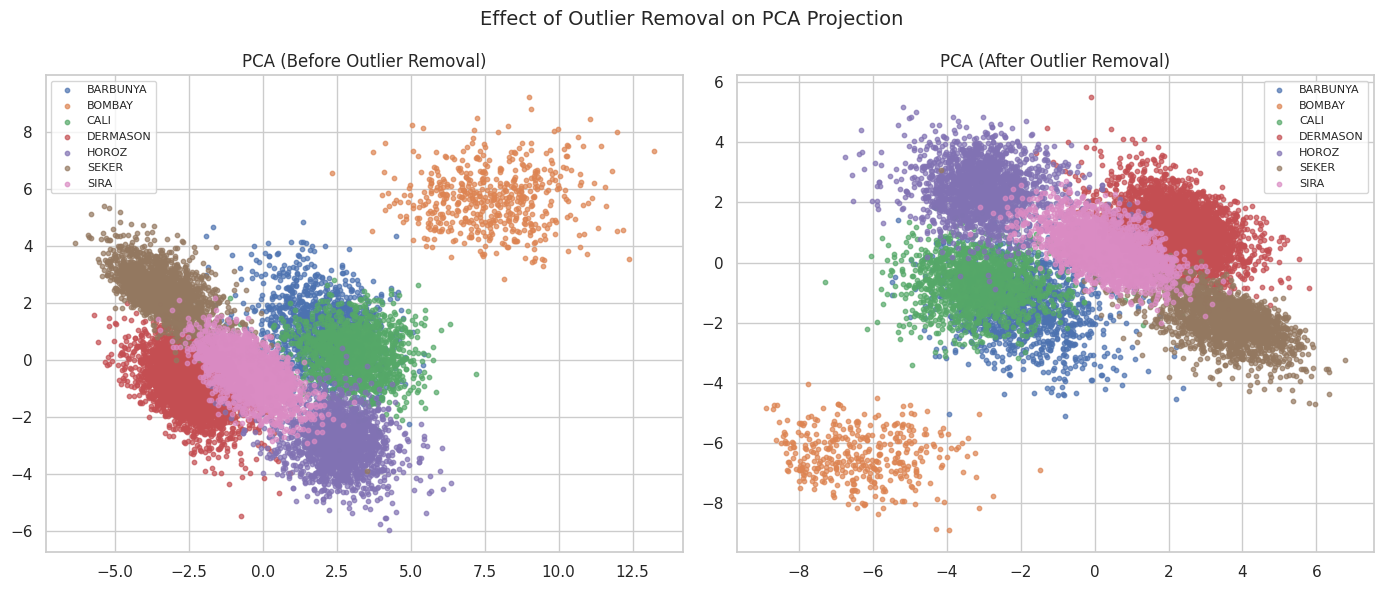

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Recompute PCA for cleaned data
pca_clean = PCA(n_components=2)
X_pca_clean = pca_clean.fit_transform(X_clean)

# Also keep the original PCA if not already stored
pca_full = PCA(n_components=2)
X_pca_full = pca_full.fit_transform(X_scaled)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# BEFORE outlier removal
for label in np.unique(y):
    idx = y == label
    axes[0].scatter(X_pca_full[idx, 0], X_pca_full[idx, 1], label=label, s=10, alpha=0.7)
axes[0].set_title("PCA (Before Outlier Removal)")
axes[0].legend(fontsize=8)

# AFTER outlier removal
for label in np.unique(y_clean):
    idx = y_clean == label
    axes[1].scatter(X_pca_clean[idx, 0], X_pca_clean[idx, 1], label=label, s=10, alpha=0.7)
axes[1].set_title("PCA (After Outlier Removal)")
axes[1].legend(fontsize=8)

plt.suptitle("Effect of Outlier Removal on PCA Projection", fontsize=14)
plt.tight_layout()
plt.show()

In [19]:
X_clean_df = pd.DataFrame(X_clean, columns=X.columns).reset_index(drop=True)
y_clean_reset = y_clean.reset_index(drop=True)

# Recalculate Fisher Scores on cleaned data
fisher_clean = calculate_fisher_distance(X_clean_df, y_clean_reset)

print("Fisher Scores AFTER Outlier Removal:")
for k, v in fisher_clean.items():
    print(f"{k}: {v:.4f}")

Fisher Scores AFTER Outlier Removal:
EquivDiameter: 3.6325
Perimeter: 3.5138
MinorAxisLength: 3.4840
ConvexArea: 3.3320
Area: 3.3265
ShapeFactor1: 3.1560
MajorAxisLength: 3.1193
ShapeFactor2: 2.3655
Compactness: 1.8491
ShapeFactor3: 1.8237
AspectRatio: 1.8069
Eccentricity: 1.5960
Roundness: 1.5145
ShapeFactor4: 0.7310
Solidity: 0.5235
Extent: 0.3847


If the average Fisher scores increase, it indicates better class separability — removing outliers made the data more discriminative.

In [20]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# Before cleaning
kmeans_before = KMeans(n_clusters=7, random_state=0).fit(X_scaled)
sil_before = silhouette_score(X_scaled, kmeans_before.labels_)

# After cleaning
kmeans_after = KMeans(n_clusters=7, random_state=0).fit(X_clean)
sil_after = silhouette_score(X_clean, kmeans_after.labels_)

print(f"Silhouette Score BEFORE Cleaning: {sil_before:.4f}")
print(f"Silhouette Score AFTER Cleaning:  {sil_after:.4f}")

Silhouette Score BEFORE Cleaning: 0.2565
Silhouette Score AFTER Cleaning:  0.2781


If the silhouette score improves, it means clusters are more compact and better separated — a direct benefit of removing outliers.